# ProtT5 Evo-Tuning

This notebook allows you to continue the unsupervised pre-training for [ProtT5](https://github.com/agemagician/ProtTrans).

In this example we show how to [evo-tune](https://www.nature.com/articles/s41592-019-0598-1) the model for the [GFP](https://www.uniprot.org/uniprotkb/P42212/entry) protein using a MSA (homolgo sequences to GFP) as training data.

For better perfomance we apply [Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/blog/peft). For this we apply [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).

The core training loop is implemented with the pytorch [huggingface trainer](https://huggingface.co/docs/transformers/main_classes/trainer).


## Imports and env. variables

In [ ]:
#import dependencies
import os.path

#set path
os.chdir("./to_your_path")


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets

from transformers import T5Tokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForLanguageModeling
from transformers import GenerationConfig
from transformers import TrainingArguments, Trainer, set_seed
from transformers import EarlyStoppingCallback

from typing import Optional, Tuple, Union, Any, List, NewType, Callable, Dict
from collections.abc import Mapping

from transformers.trainer_callback import TrainerCallback

import peft
from peft import get_peft_config, PeftModel, PeftConfig, LoraConfig, get_peft_model

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from Bio import SeqIO

import matplotlib.pyplot as plt

# Environment to run this notebook


These are the versions of the core packages we use to run this notebook:

In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  1.13.1
Cuda version:  11.7
Numpy version:  1.22.3
Pandas version:  1.5.3
Transformers version:  4.47.1
Datasets version:  2.9.0


# Model checkpoint

In [3]:
checkpoint = "Rostlab/prot_t5_xl_uniref50"

# Input data

We load two files:



1.   A MSA fasta file holding homologs to the wildtype GFP sequence
2.   A csv-file holding randomly selected SwissProt entries, which we use as additional validation set



In [4]:
from Bio import SeqIO
from io import StringIO
import requests

#1: GFP MSA sequences with 85 homolog sequences
# GFP wildtye entry: https://www.uniprot.org/uniprotkb/P42212/entry
# Load training sequences
url = 'https://raw.githubusercontent.com/RSchmirler/ProtT5-EvoTuning/refs/heads/main/data/GFP_AEQVI_MSA.fasta'

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Create a StringIO object to simulate a file-like object
fasta_file = StringIO(response.text)

# Load FASTA file using Biopython
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append([record.name, str(record.seq)])

# Create dataframe
df_gfp = pd.DataFrame(sequences, columns=["name", "sequence"])
df_gfp.head(5)

,name,sequence
0,UniRef90_A0A4S2H6I4_1.0,NILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD...
1,UniRef90_UPI001C43669A_1.0,MTMITPSLHACRSTLEDPRVPVEKMSKGEELFTGVVPILVELDGDV...
2,UniRef90_UPI0000D5BE54_0.999,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...
3,UniRef90_UPI00022F83CA_0.993,MRGSHHHHHHGMASMTGGQQMGRDLYDDDDKDRWGSKIEEGKLVIW...
4,UniRef90_A0A1V4T0E4_0.993,MRDPASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKL...


In [5]:
#2: Random subset of ~1100 SwissProt sequences

# Load training sequences
url = 'https://raw.githubusercontent.com/RSchmirler/ProtT5-EvoTuning/refs/heads/main/data/swissprot_protein_level_subset.tsv'

response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Create a StringIO object to simulate a file-like object
tsv_file = StringIO(response.text)

# Load the TSV content into a pandas DataFrame
df_swissprot = pd.read_csv(tsv_file, sep='\t')

# Display the first few rows of the DataFrame
df_swissprot.head()

,Entry,Entry Name,Organism,Length,sequence
0,Q9S736,OBE1_ARATH,Arabidopsis thaliana (Mouse-ear cress),566,MGTSSGSNLPHQMLPPRQQLQTSLSLVSSDPHLSRSNSGIVRESPA...
1,Q9Y0Y0,CECB1_AEDAL,Aedes albopictus (Asian tiger mosquito) (Stego...,60,MNFNKLFALVLLIGLVLLTGQTEAGGLKKLGKKLEGVGKRVFKASE...
2,B8NNN3,AP1_ASPFN,Aspergillus flavus (strain ATCC 200026 / FGSC ...,584,MADYNTLYHQGLYLSPDQQDLLLAALSSNQPPQKQQNDKQRSQAKT...
3,Q8K0E3,SC5AB_MOUSE,Mus musculus (Mouse),673,MESATISPQPPQSDSLEAFPQKSMEPADIAVLVLYFLFVLAVGLWS...
4,O42906,GPN1_SCHPO,Schizosaccharomyces pombe (strain 972 / ATCC 2...,367,MTDKEKKPCAIIVVGMAGSGKTTFMQQLNAHLHSKNKPPYILNLDP...


**Modify the data loading part above as needed for your data**

Each dataset should contain a **sequence** column

# Models and Low Rank Adaptation

## T5 Models

In [6]:
def load_T5_model(checkpoint):

    # Load model and tokenizer

    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, force_download=False)
    tokenizer = T5Tokenizer.from_pretrained(checkpoint, force_download=False)

    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_EncDec\nTrainable Parameter: "+ str(params))

    # lora modification
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["q","k","v","o"], task_type = "SEQ_2_SEQ_LM",
    )

    # create peft SEQ_2_SEQ_LM model
    model = get_peft_model(model, peft_config)

    # Print trainable Parameter
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_LoRA_EncDec\nTrainable Parameter: "+ str(params) + "\n")

    return model, tokenizer

# Training Definition

## Training functions

In [7]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters
    torch.save(non_frozen_params, filepath)


def load_model(checkpoint, filepath):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load model
    model, tokenizer = load_T5_model(checkpoint)

    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [8]:
def shift_right(input_ids):
    decoder_start_token_id = 0
    pad_token_id = 0

    shifted_input_ids = torch.full(input_ids.shape[:-1] + (1,), decoder_start_token_id)
    shifted_input_ids = torch.cat([shifted_input_ids, input_ids[..., :-1]], dim=-1)

    return shifted_input_ids


def pad_without_fast_tokenizer_warning(tokenizer, *pad_args, **pad_kwargs):
    """
    Pads without triggering the warning about how using the pad function is sub-optimal when using a fast tokenizer.
    """

    # To avoid errors when using Feature extractors
    if not hasattr(tokenizer, "deprecation_warnings"):
        return tokenizer.pad(*pad_args, **pad_kwargs)

    # Save the state of the warning, then disable it
    warning_state = tokenizer.deprecation_warnings.get("Asking-to-pad-a-fast-tokenizer", False)
    tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

    try:
        padded = tokenizer.pad(*pad_args, **pad_kwargs)
    finally:
        # Restore the state of the warning.
        tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = warning_state

    return padded

class T5DataCollatorForPretraining(DataCollatorForLanguageModeling):
    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:

        # Handle dict or lists with proper padding and conversion to tensor.
        if isinstance(examples[0], Mapping):
            batch = pad_without_fast_tokenizer_warning(
                self.tokenizer, examples, return_tensors="pt", pad_to_multiple_of=self.pad_to_multiple_of
            )

        else:
            batch = {
                "input_ids": _torch_collate_batch(examples, self.tokenizer, pad_to_multiple_of=self.pad_to_multiple_of)
            }

        # If special token mask has been preprocessed, pop it from the dict.
        special_tokens_mask = batch.pop("special_tokens_mask", None)
        if self.mlm:
            batch["input_ids"], batch["labels"], batch["decoder_input_ids"] = self.torch_mask_tokens(
                batch["input_ids"], special_tokens_mask=special_tokens_mask
            )

        else:
            labels = batch["input_ids"].clone()
            if self.tokenizer.pad_token_id is not None:
                labels[labels == self.tokenizer.pad_token_id] = -100
            batch["labels"] = labels

        return batch


    def torch_mask_tokens(self, inputs: Any, special_tokens_mask: Optional[Any] = None) -> Tuple[Any, Any, Any]:
        """
        Prepare masked tokens inputs/labels for masked language modeling: 100% MASK
        """
        labels = inputs.clone()
        # We sample a few tokens in each sequence for MLM training (with probability `self.mlm_probability`)
        probability_matrix = torch.full(labels.shape, self.mlm_probability)
        if special_tokens_mask is None:
            special_tokens_mask = [
                self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
            ]
            special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
        else:
            special_tokens_mask = special_tokens_mask.bool()

        probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        labels[~masked_indices] = -100  # We only compute loss on masked tokens

        # Create decoder inputs
        decoder_inputs = shift_right(inputs)

        # For ProtT5 pre-training we replace ALL masked input tokens with tokenizer.mask_token ([MASK])
        inputs[masked_indices] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        return inputs, labels, decoder_inputs

In [9]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs):

    tokenized = tokenizer(seqs, max_length=1024, padding=False, truncation=True)
    dataset = Dataset.from_dict(tokenized)

    return dataset


# Main training fuction
def train_per_protein(
        checkpoint,       #model checkpoint
        train_df,         #training data (GFP MSA)
        valid_df,         #validation data (Swiss-Prot subset)

        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8
        batch = 4,        #for training
        accum = 2,        #gradient accumulation

        val_batch = 1,   #batch size for evaluation
        epochs = 10,      #training epochs
        lr = 3e-4,        #recommended learning rate
        seed = 42,        #random seed
        mixed = True,     #enable mixed precision training
        gpu = 1 ):        #gpu selection (1 for first gpu)


    print("Model used:", checkpoint, "\n")

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)

    # Set all random seeds
    set_seeds(seed)

    # load model
    model, tokenizer = load_T5_model(checkpoint)

    #provide the mask token, not the id
    tokenizer.mask_token = "<extra_id_0>"

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)

    # Add spaces between each amino acid for ProtT5 and ProstT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Create Datasets (tokenize labels as well)
    train_set=create_dataset(tokenizer,list(train_df['sequence']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']))

    # Create a dict to use both datasets for evaluation
    val_dict = {"Swiss-Prot": valid_set, "GFP-MSA": train_set}

    # Huggingface Trainer arguments
    args = Seq2SeqTrainingArguments(
        "./",
        eval_strategy = "steps",
        eval_steps = 20,
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate = lr,
        lr_scheduler_type = "cosine",
        warmup_steps = 0,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        fp16 = mixed,
    )

    # Metric definition for validation data

    def compute_metrics(eval_pred):
        # Unpack logits and labels from EvalPrediction
        logits_tuple, labels = eval_pred
        # Select the first element, assuming it's the logits

        logits = logits_tuple[0]

        # Convert logits and labels to tensors
        logits_tensor = torch.tensor(logits, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        # Initialize the mask to select only predictions where labels are not -100
        mask = labels_tensor != -100

        # Select only the masked elements
        masked_logits = logits_tensor[mask].view(-1, logits_tensor.shape[-1])
        masked_labels = labels_tensor[mask].view(-1)

        # Calculate the loss for masked tokens
        loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fn(masked_logits, masked_labels)

        # Compute the average loss
        average_loss = loss.mean().item()

        # Perplexity is the exponential of the average cross-entropy loss
        perplexity = np.exp(average_loss)

        # Calculate accuracy (correct demasking)
        # Get the predicted tokens by finding the index of the max logit
        _, predicted_tokens = torch.max(masked_logits, dim=-1)
        # Compare predicted tokens with actual tokens and compute accuracy
        correct_predictions = (predicted_tokens == masked_labels).sum().item()
        accuracy = correct_predictions / masked_labels.size(0)

        return {"perplexity": perplexity, "accuracy": accuracy}


    data_collator = T5DataCollatorForPretraining(tokenizer,checkpoint)

    #define device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    #create dir for saving model checkpoints
    os.makedirs("./checkpoints")

    #custom callback to save model
    class SaveCallback(TrainerCallback):
        def on_epoch_end(self, args, state, control, logs=None, **kwargs):

                if (int(state.epoch) % 2 == 0) and int(state.epoch) != 0:
                    inf_model=kwargs['model'].to(device)
                    inf_model.eval()

                    #save_model
                    save_model(inf_model, "./checkpoints/GFP_EvoTuning_step_" + str(int(state.global_step)) + ".pth")

    # Trainer
    trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=val_dict,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[SaveCallback()]
    )

    trainer.train()

    return tokenizer, model, trainer.state.log_history


# Run Training

## Training

In [10]:
tokenizer, model, history = train_per_protein(checkpoint, df_gfp, df_swissprot, batch = 1, accum = 8, epochs = 30, seed = 42, mixed = False, gpu=1)

Model used: Rostlab/prot_t5_xl_uniref50 



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5_EncDec
Trainable Parameter: 2818830336
T5_LoRA_EncDec
Trainable Parameter: 5900288



Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Swiss-prot Loss,Swiss-prot Perplexity,Swiss-prot Accuracy,Gfp-msa Loss,Gfp-msa Perplexity,Gfp-msa Accuracy
20,17.131900,No log,1.195288,3.210354,0.643921,2.167026,6.438691,0.423091
40,16.978300,No log,1.192221,3.168258,0.647096,2.172364,6.538612,0.419545
60,17.045400,No log,1.174747,3.180949,0.637874,2.119353,6.179417,0.441455
80,16.572700,No log,1.196288,3.204035,0.641870,2.084691,6.046345,0.450380
100,15.930100,No log,1.201769,3.241283,0.635920,1.925049,5.288980,0.484881
120,15.266600,No log,1.192252,3.245801,0.635460,1.720150,4.569580,0.532261
140,13.704800,No log,1.179757,3.163413,0.643181,1.497226,3.817971,0.591442
160,12.054100,No log,1.190167,3.252241,0.639440,1.306638,3.288134,0.642597
180,10.750900,No log,1.199766,3.200798,0.642244,1.154923,2.947627,0.673882
200,9.986900,No log,1.206415,3.208712,0.635995,1.092010,2.775202,0.694531


## Plot results

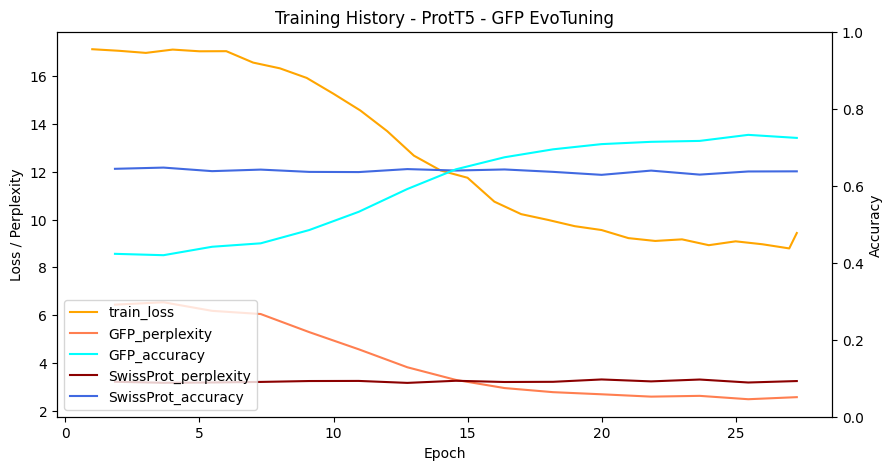

In [13]:
loss = [x['loss'] for x in history if 'loss' in x]

# Get spearman (for regression) or accuracy value (for classification)

metric = [x['eval_Swiss-Prot_perplexity'] for x in history if 'eval_Swiss-Prot_perplexity' in x]
metric2 = [x['eval_GFP-MSA_perplexity'] for x in history if 'eval_GFP-MSA_perplexity' in x]

acc = [x['eval_Swiss-Prot_accuracy'] for x in history if 'eval_Swiss-Prot_accuracy' in x]
acc2 = [x['eval_GFP-MSA_accuracy'] for x in history if 'eval_GFP-MSA_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]
epochsv = [x['epoch'] for x in history if 'eval_Swiss-Prot_perplexity' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, color="orange", label='train_loss')
line2 = ax1.plot(epochsv, metric2, color='coral', label='GFP_perplexity')
line3 = ax1.plot(epochsv, metric, color='darkred', label='SwissProt_perplexity')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss / Perplexity')

# Plot the computed metric on the second y-axisload_model
line4 = ax2.plot(epochsv, acc, color='royalblue', label='SwissProt_accuracy')
line5 = ax2.plot(epochsv, acc2, color='cyan', label='GFP_accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line5 + line3 + line4
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History - ProtT5 - GFP EvoTuning")
plt.show()

# Load the EvoTuned GFP-model and merge adapter

In [15]:
# load one of the saved model checkpoints
tokenizer, model = load_model(checkpoint, "./checkpoints/GFP_EvoTuning_step_286.pth")

T5_EncDec
Trainable Parameter: 2818830336
T5_LoRA_EncDec
Trainable Parameter: 5900288



In [17]:
# Optional:
# merge the trained LoRA adapter into the original model
# this can be useful to continue working with the Evo-Tuned model (e.g. for fine-tuning it on some downstream task)
model.cpu().merge_and_unload('default')

Unloading and merging model: 100%|██████████| 1357/1357 [00:00<00:00, 1375.54it/s]


T5ForConditionalGeneration(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dro